In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mstats
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
# run for jupyter notebook
from IPython.core.debugger import Tracer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#%%

/home/alal/anaconda3/envs/gds/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Shapefiles

In [2]:
root = '/media/alal/LAL_DATA/Data/Geodata/Nepal/Nepal_Admin_Boundaries'
%cd $root
# l1 = gpd.read_file('Regions Level 1.shp')
# l2 = gpd.read_file('Zones Level 2.shp')
# l5 = gpd.read_file('Wards Level 5.shp')
l3 = gpd.read_file('Districts Level 3.shp')
l4 = gpd.read_file('villages/npl_popu_pop_py_s1_wfp_2011adm4.shp')

/media/alal/LAL_DATA/Data/Geodata/Nepal/Nepal_Admin_Boundaries


In [3]:
dist_map = gpd.read_file('/media/alal/LAL_DATA/Data/Geodata/Nepal/Nepal_Admin_Boundaries/NPL_adm_shp/NPL_adm2.shp')

## Household Data

In [4]:
working = '/home/alal/Desktop/code/0_research/eq-svy-eda'
maproot = '/home/alal/Desktop/code/0_research/eq-svy-eda/reports/maps'
%cd $working
%time hh_all = pd.read_csv(working+'/data/interim/hh_with_geo.csv')

/home/alal/Desktop/code/0_research/eq-svy-eda


<string>:2: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 6.13 s, sys: 1.09 s, total: 7.22 s
Wall time: 7.89 s


In [5]:
hh_all['vdc']=hh_all['VDC-Municipality-Name'].str.lower()

In [6]:
main_dists = hh_all.loc[hh_all.FullSample==1].District_Name.unique()
main_dists

array(['okhaldhunga', 'sindhuli', 'ramechhap', 'dolakha', 'sindhupalchok',
       'kavrepalanchok', 'nuwakot', 'rasuwa', 'dhading', 'makwanpur',
       'gorkha'], dtype=object)

### Subset and Merge - District Level

In [7]:
l3['District'] = l3['DISTRICT'].str.lower()

In [8]:
remaps = {"makawanpur": "makwanpur",
         "kabhrepalanchok": "kavrepalanchok",
         "chitawan": "chitwan"}
l3['District'].replace(remaps, inplace=True)
main_dists_shp = l3.loc[l3['District'].isin(main_dists)]

## Study Area Map

In [10]:
f, ax = plt.subplots(1,dpi=300)

dist_map.plot(facecolor='grey',ax=ax,linewidth=5)
main_dists_shp.plot(facecolor='blue',ax=ax,linewidth=5)
ax.set_axis_off()
f.suptitle('Study area : Worst-affected Districts')
plt.savefig('{0}_plot.png'.format('study_area'), dpi=300)
plt.close()

Text(0.5,0.98,'Study area : Worst-affected Districts')

In [11]:
main_dists_eq = hh_all[hh_all['District_Name'].isin(main_dists)]

In [12]:
# set income to lower-bound of each bin
incomes = {
    'Rs. 10 thousand':5000, 
    'Rs. 10-20 thousand':10000,
    'Rs. 20-30 thousand':20000, 
    'Rs. 30-50 thousand':30000, 
    'Rs. 50 thousand or more':50000
}
main_dists_eq['income'] = main_dists_eq['income_level_household'].map(incomes)

/home/alal/anaconda3/envs/gds/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Functions to group and plot

In [13]:
def aggregate_indicator(var,oper='sum'):
    dist_lev_tallies = main_dists_eq.groupby('District_Name').agg({
        'household_id': 'count',
        var : oper
    })
    dist_lev_tallies.reset_index(inplace=True)
    dist_lev_tallies.rename(columns={'household_id': 'number_of_households'}, inplace=True)
    if oper == 'sum':
        dist_lev_tallies['share_with_'+var]=\
                        (dist_lev_tallies[var]/\
                        dist_lev_tallies.number_of_households)*100
    return dist_lev_tallies

In [14]:
def plot_variable(df,varn,save=False,label=''):
    merged_dist = main_dists_shp.merge(df,
                     left_on='District',right_on='District_Name')
    merged_dist['coords'] = merged_dist['geometry'].apply(lambda x: x.representative_point().coords[:])
    merged_dist['coords'] = [coords[0] for coords in merged_dist['coords']]
    f, ax = plt.subplots(1,dpi=300)
    merged_dist.plot(column=varn,ax=ax,cmap=plt.cm.viridis,
                    legend=True,linewidth=5)
    for idx, row in merged_dist.iterrows():
        plt.annotate(s=row['District'], xy=row['coords'],
                     horizontalalignment='center',size=5)
    ax.set_axis_off()
    if label == '' : 
        label = varn
    f.suptitle(label)
    if save:
        plt.savefig('{0}_plot.png'.format(varn), dpi=300)
        plt.clf()

## District level summaries and plots

District_Name  has_death_occurred_last_12_months  number_of_households  \
0          dhading                             1921.0                 80942   
1          dolakha                              897.0                 68112   
2           gorkha                             1556.0                 69328   
3   kavrepalanchok                             1784.0                 80972   
4        makwanpur                             1182.0                 68628   
5          nuwakot                             2254.0                 75454   
6      okhaldhunga                              563.0                 32678   
7        ramechhap                              739.0                 47817   
8           rasuwa                              630.0                 12384   
9         sindhuli                              698.0                 52252   
10   sindhupalchok                             3931.0                 79822   

    share_with_has_death_occurred_last_12_months  
0                                       2.373304  
1                                       1.316949  
2                                       2.244403  
3                                       2.203231  
4                                       1.722329  
5                                       2.987251  
6                                       1.722872  
7                                       1.545475  
8                                       5.087209  
9                                       1.335834  
10                                      4.924707

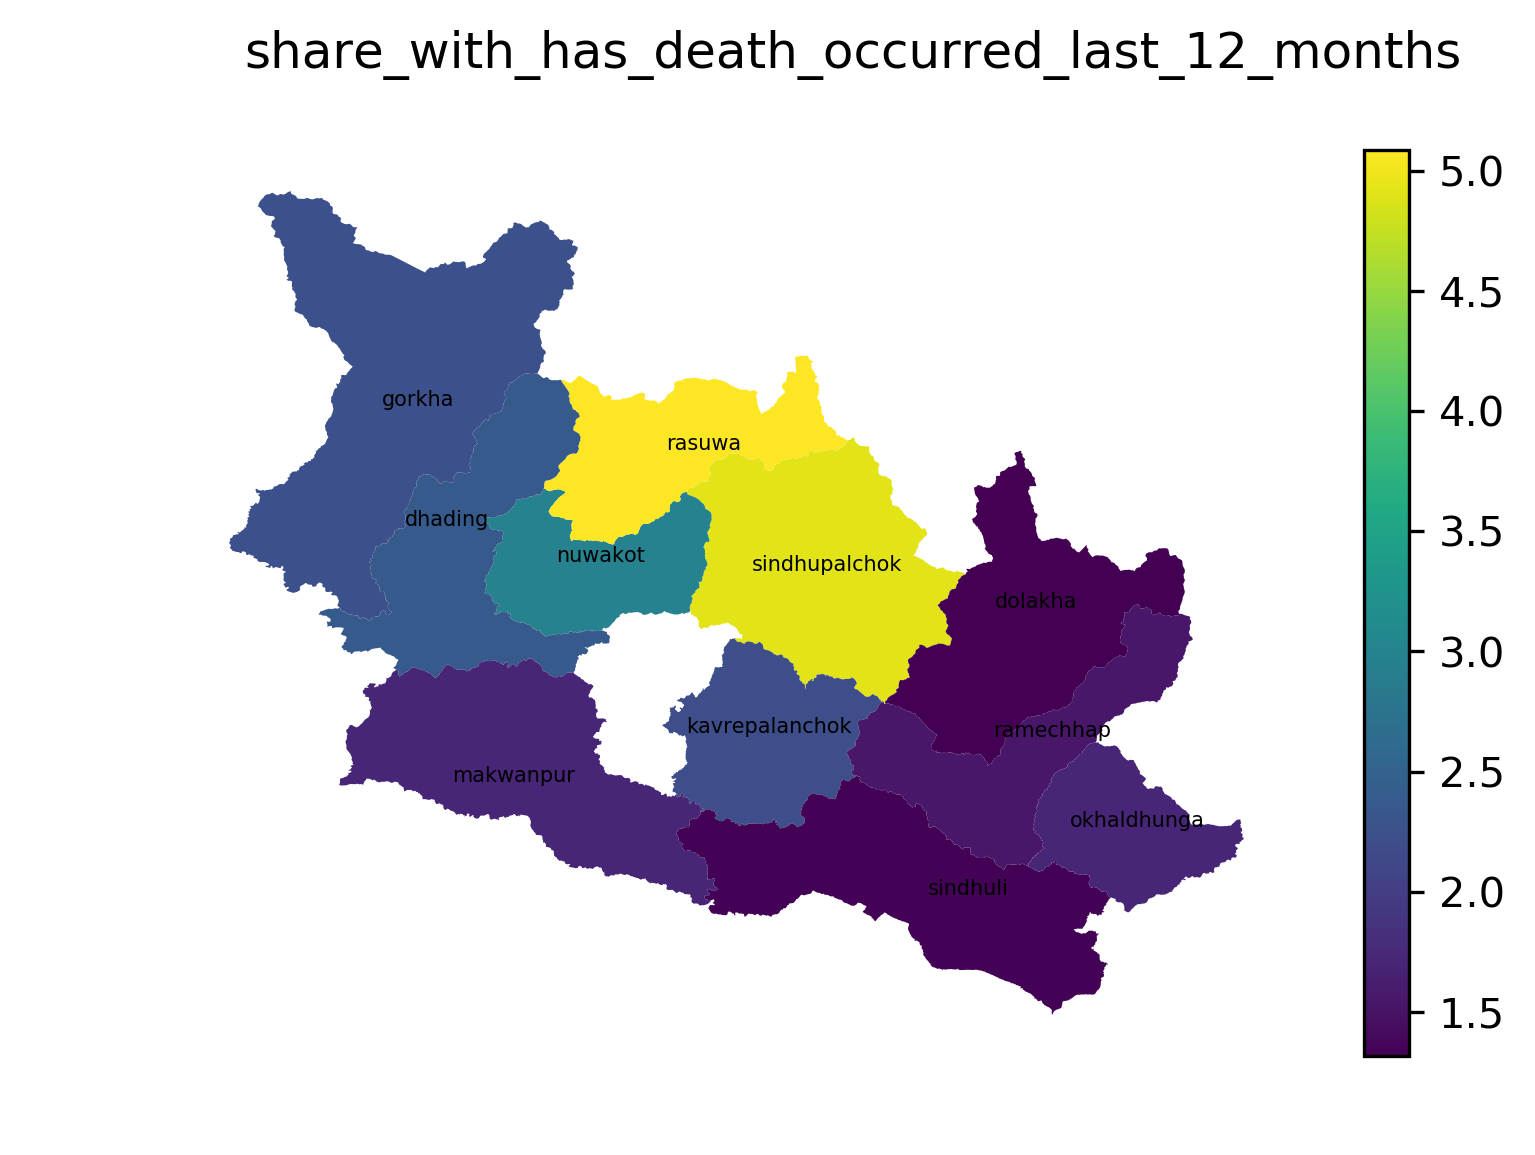

In [15]:
v = 'has_death_occurred_last_12_months'
df = aggregate_indicator(v)
df
plot_variable(df,'share_with_'+v)

District_Name  is_recipient_rahat_10k  number_of_households  \
0          dhading                   65321                 80942   
1          dolakha                   52101                 68112   
2           gorkha                   55935                 69328   
3   kavrepalanchok                   58435                 80972   
4        makwanpur                    5643                 68628   
5          nuwakot                   65525                 75454   
6      okhaldhunga                   12984                 32678   
7        ramechhap                   42337                 47817   
8           rasuwa                    9936                 12384   
9         sindhuli                   17153                 52252   
10   sindhupalchok                   69092                 79822   

    share_with_is_recipient_rahat_10k  
0                           80.700996  
1                           76.493129  
2                           80.681687  
3                           72.166922  
4                            8.222591  
5                           86.840989  
6                           39.733154  
7                           88.539641  
8                           80.232558  
9                           32.827452  
10                          86.557591

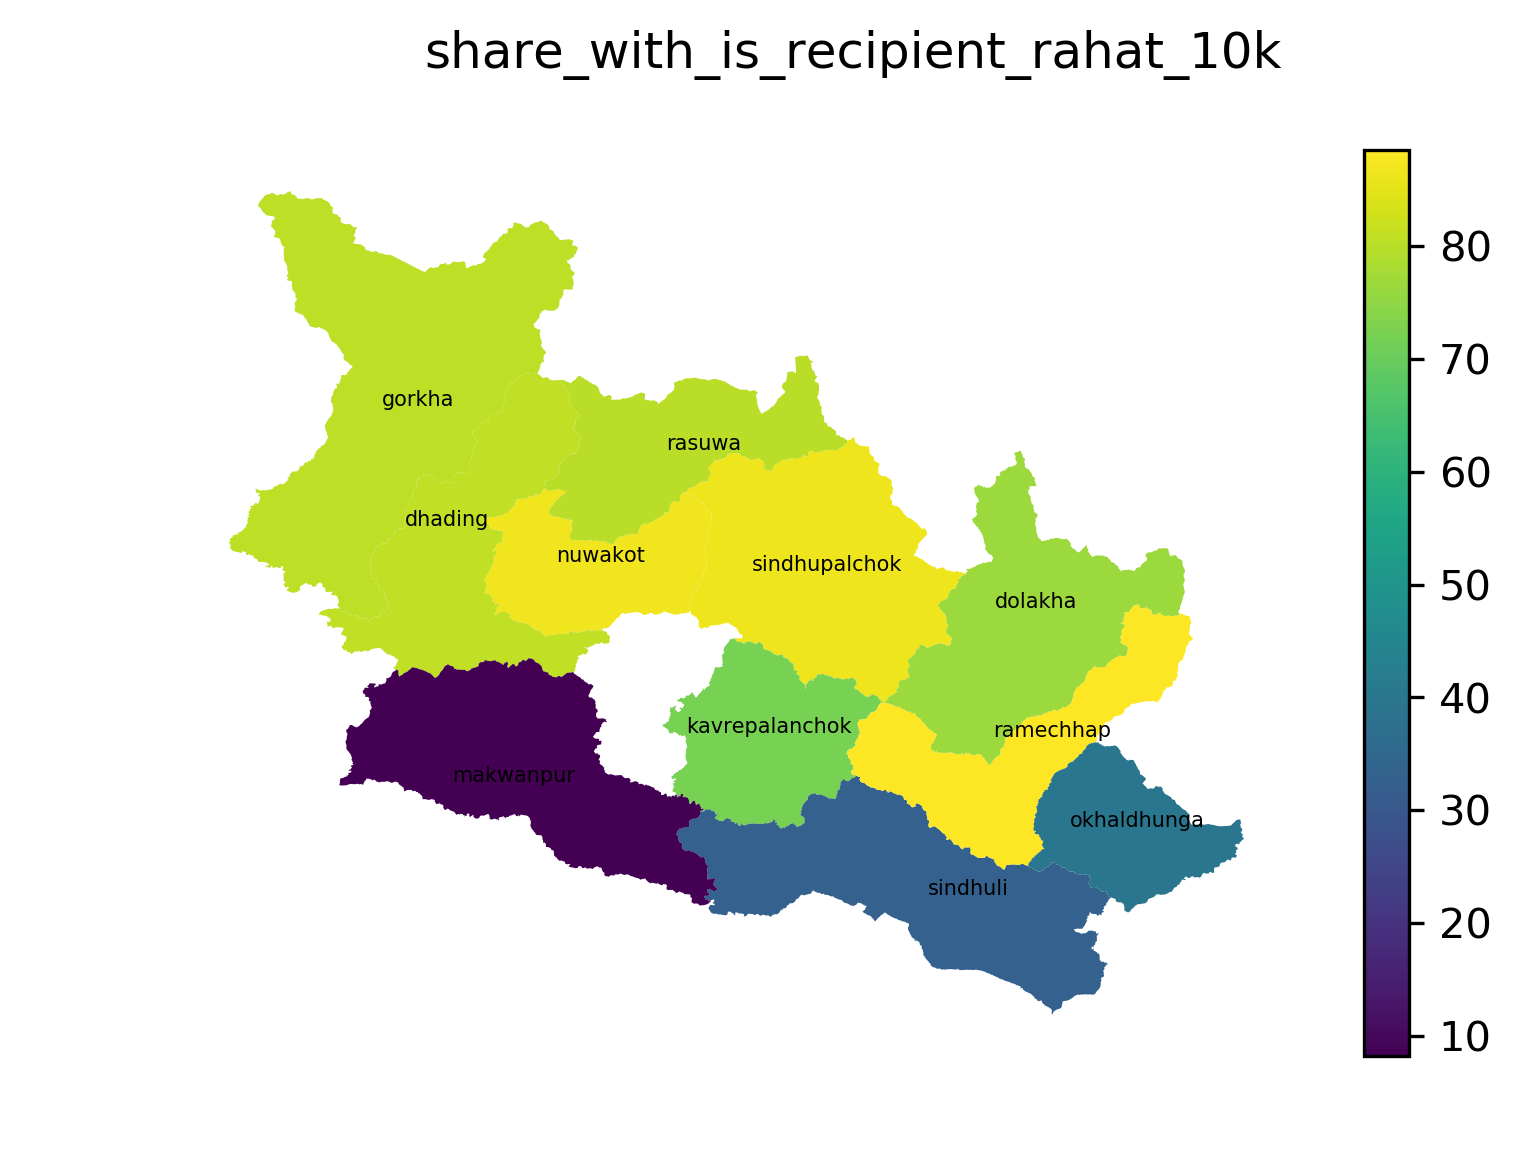

In [16]:
v = 'is_recipient_rahat_10k'
df = aggregate_indicator(v)
df
plot_variable(df,'share_with_'+v)

District_Name  number_of_households        income
0          dhading                 80942   9612.575087
1          dolakha                 68112   9560.717065
2           gorkha                 69328   9771.861472
3   kavrepalanchok                 80972  10103.752378
4        makwanpur                 68628   9660.899503
5          nuwakot                 75454   9369.009267
6      okhaldhunga                 32678   7526.778063
7        ramechhap                 47817   7848.581827
8           rasuwa                 12384   9491.518578
9         sindhuli                 52252   7762.168163
10   sindhupalchok                 79822   9645.850823

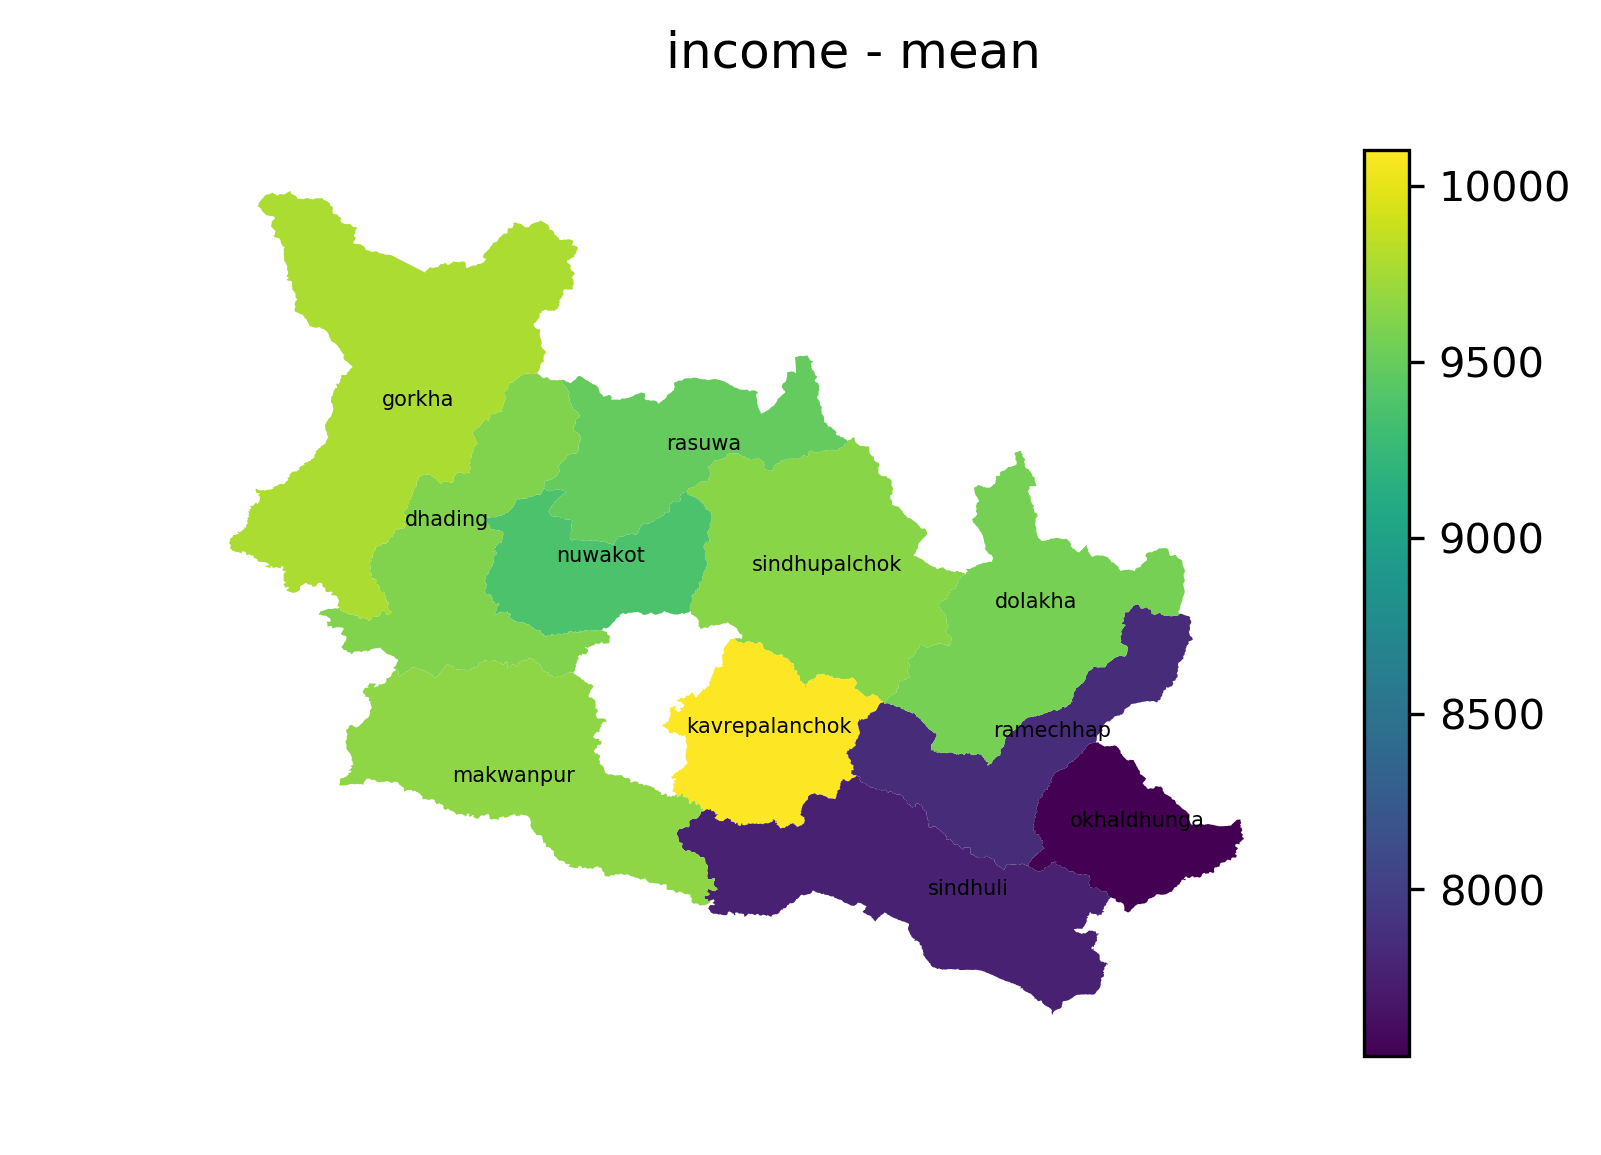

In [38]:
v = 'income'
aggregate_indicator(v,oper='mean')
plot_variable(aggregate_indicator(v,oper='mean'),v,label='income - mean')

District_Name  number_of_households       income
0          dhading                 80942  7486.948590
1          dolakha                 68112  7146.871076
2           gorkha                 69328  8198.749024
3   kavrepalanchok                 80972  7603.916667
4        makwanpur                 68628  7861.461098
5          nuwakot                 75454  7136.288861
6      okhaldhunga                 32678  5539.319201
7        ramechhap                 47817  5700.993407
8           rasuwa                 12384  7130.080013
9         sindhuli                 52252  5528.135851
10   sindhupalchok                 79822  7809.010257

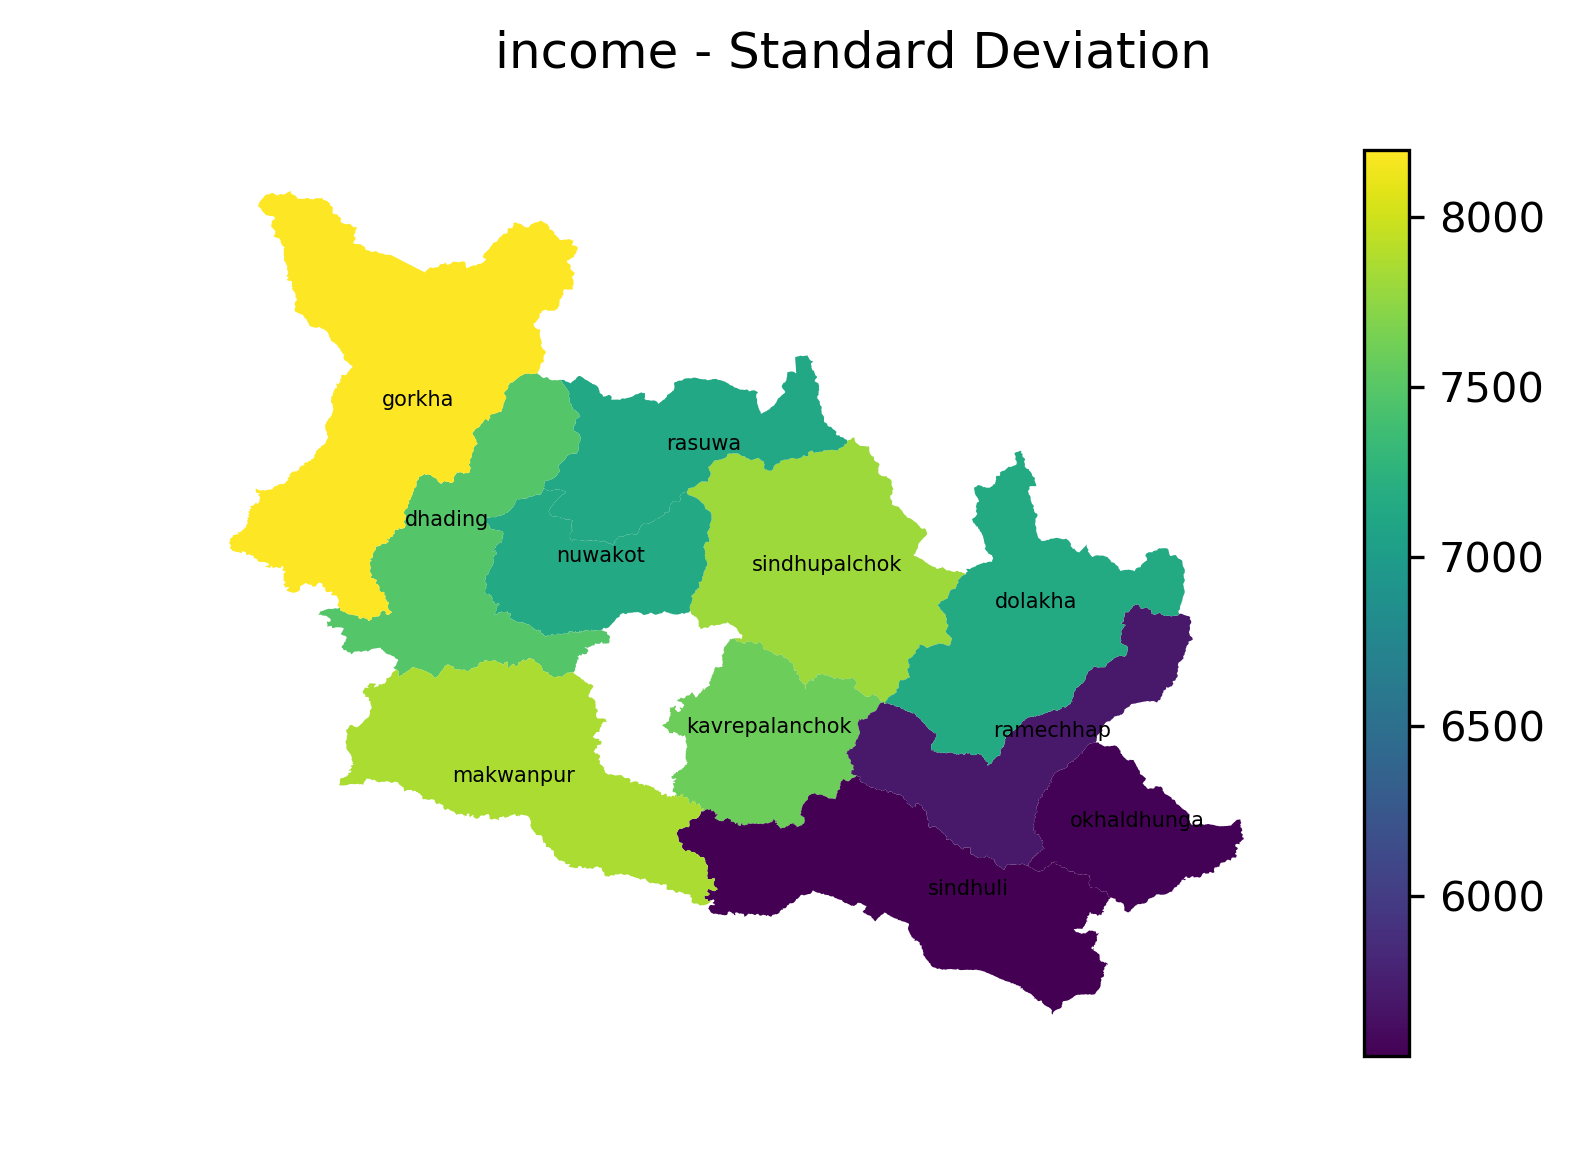

In [39]:
v = 'income'
aggregate_indicator(v,oper='std')
plot_variable(aggregate_indicator(v,oper='std'),v,label='income - Standard Deviation')

In [17]:
%cd $maproot

/home/alal/Desktop/code/0_research/eq-svy-eda/reports/maps


In [41]:
! mkdir 'district_level' -p

In [42]:
%cd 'district_level'

/home/alal/Desktop/code/0_research/eq-svy-eda/reports/maps/district_level


In [18]:
list_of_cols = ['is_bank_account_present_in_household',
    'has_death_occurred_last_12_months', 
    'has_injury_loss_occurred_last_12_months',
    'has_education_drop_occurred_last_12_months',
    'has_pregnancy_treatment_drop_occurred_last_12_months',
    'has_vaccination_drop_occurred_last_12_months',
    'has_occupation_change_occurred_last_12_months',
    'count_occupation_change_last_12_months',
    'is_recipient_rahat_15k', 'is_recipient_rahat_10k',
    'is_recipient_rahat_200k', 'is_recipient_rahat_social_security_3k',
    'is_recipient_rahat_none', 'is_ineligible_rahat',
    'has_asset_land_pre_eq', 'has_asset_tv_pre_eq',
    'has_asset_cable_pre_eq', 'has_asset_computer_pre_eq',
    'has_asset_internet_pre_eq', 'has_asset_telephone_pre_eq',
    'has_asset_mobile_phone_pre_eq', 'has_asset_fridge_pre_eq',
    'has_asset_motorcycle_pre_eq',
    'has_asset_four_wheeler_family_use_pre_eq',
    'has_asset_four_wheeler_commercial_use_pre_eq', 'has_asset_none_pre_eq',
    'has_asset_land_post_eq', 'has_asset_tv_post_eq',
    'has_asset_cable_post_eq', 'has_asset_computer_post_eq',
    'has_asset_internet_post_eq', 'has_asset_telephone_post_eq',
    'has_asset_mobile_phone_post_eq', 'has_asset_fridge_post_eq',
    'has_asset_motorcycle_post_eq',
    'has_asset_four_wheeler_family_use_post_eq',
    'has_asset_four_wheeler_commercial_post_eq', 'has_asset_none_post_eq'
]

In [20]:
%%capture
for v in list_of_cols:
    plot_variable(aggregate_indicator(v),'share_with_'+v,True)

## Merge Village level

In [19]:
dist_remaps = {"makawanpur": "makwanpur",
         "kabhrepalanchok": "kavrepalanchok",
         "chitawan": "chitwan"}

In [20]:
l4.head()

AREA     PERIMETER  DIST_ID   SURVEY_NAM  VDC_ID   DISTRICT  \
0  4.105794e+07  29183.311857       31         AGRA       1  Makwanpur   
1  4.019532e+07  29102.589030       31  AMBHANJYANG       2  Makwanpur   
2  1.791865e+07  21397.431423       31  BAJRABARAHI       3  Makwanpur   
3  2.836742e+07  33559.926104       31       BHARTA       7  Makwanpur   
4  4.408413e+07  33985.626676       31    BHIMPHEDI       8  Makwanpur   

           VDC_NAME  VDC_CODE ZONE_NAME   REGION        P_CODE  HHs2011  \
0             Agara  310001.0  Narayani  Central  C-NAR-31-001   1572.0   
1       Ambhanjyang  310002.0  Narayani  Central  C-NAR-31-002   1403.0   
2       Bajrabarahi  310003.0  Narayani  Central  C-NAR-31-003   1630.0   
3  BhartaPundyadevi  310007.0  Narayani  Central  C-NAR-31-007    693.0   
4          Bhimfedi  310008.0  Narayani  Central  C-NAR-31-008   1161.0   

   Popn2011  Male2011  Female2011  Popden2011  \
0    7836.0    3850.0      3986.0      190.83   
1    6906.0    3330.0      3576.0      171.81   
2    7675.0    3622.0      4053.0      428.34   
3    4169.0    2143.0      2026.0      146.97   
4    5440.0    2503.0      2937.0      123.40   

                                            geometry  
0  POLYGON ((85.0006120230358 27.70604096927096, ...  
1  POLYGON ((85.11448595626297 27.47546204115448,...  
2  POLYGON ((85.14539169624412 27.67058622718741,...  
3  POLYGON ((84.92941845258598 27.61343972136995,...  
4  POLYGON ((85.12177777460754 27.58062466786436,...

In [21]:
main_dists

array(['okhaldhunga', 'sindhuli', 'ramechhap', 'dolakha', 'sindhupalchok',
       'kavrepalanchok', 'nuwakot', 'rasuwa', 'dhading', 'makwanpur',
       'gorkha'], dtype=object)

In [22]:
main_dists_shp.District.unique()

array(['sindhupalchok', 'kavrepalanchok', 'nuwakot', 'rasuwa', 'dhading',
       'sindhuli', 'ramechhap', 'dolakha', 'makwanpur', 'okhaldhunga',
       'gorkha'], dtype=object)

In [23]:
l4['District'] = l4['DISTRICT'].str.lower()
main_dists_shp = l4.loc[l4['District'].isin(main_dists)]
main_dists_shp.shape

(627, 18)

In [24]:
main_dists_eq.head()

VDC-Municipality-Code VDC-Municipality-Name  District District_Name  \
287278                    2.0                 Baksa      12.0   okhaldhunga   
287279                    2.0                 Baksa      12.0   okhaldhunga   
287280                    2.0                 Baksa      12.0   okhaldhunga   
287281                    2.0                 Baksa      12.0   okhaldhunga   
287282                    2.0                 Baksa      12.0   okhaldhunga   

        FullSample   household_id  district_id  vdcmun_id  ward_id  \
287278         1.0  1202010001101           12       1202   120201   
287279         1.0  1202010002101           12       1202   120201   
287280         1.0  1202010003101           12       1202   120201   
287281         1.0  1202010004101           12       1202   120201   
287282         1.0  1202010005101           12       1202   120201   

       gender_household_head   ...     has_asset_internet_post_eq  \
287278                  Male   ...                              0   
287279                  Male   ...                              0   
287280                  Male   ...                              0   
287281                Female   ...                              0   
287282                Female   ...                              0   

       has_asset_telephone_post_eq has_asset_mobile_phone_post_eq  \
287278                           0                              0   
287279                           0                              1   
287280                           0                              1   
287281                           0                              0   
287282                           0                              1   

       has_asset_fridge_post_eq  has_asset_motorcycle_post_eq  \
287278                        0                             0   
287279                        0                             0   
287280                        0                             0   
287281                        0                             1   
287282                        0                             0   

        has_asset_four_wheeler_family_use_post_eq  \
287278                                          0   
287279                                          0   
287280                                          0   
287281                                          0   
287282                                          0   

        has_asset_four_wheeler_commercial_post_eq has_asset_none_post_eq  \
287278                                          0                      0   
287279                                          0                      0   
287280                                          0                      0   
287281                                          0                      0   
287282                                          0                      0   

          vdc   income  
287278  baksa   5000.0  
287279  baksa  20000.0  
287280  baksa  10000.0  
287281  baksa  10000.0  
287282  baksa   5000.0  

[5 rows x 75 columns]

In [25]:
main_dists_shp.head()

AREA     PERIMETER  DIST_ID   SURVEY_NAM  VDC_ID   DISTRICT  \
0  4.105794e+07  29183.311857       31         AGRA       1  Makwanpur   
1  4.019532e+07  29102.589030       31  AMBHANJYANG       2  Makwanpur   
2  1.791865e+07  21397.431423       31  BAJRABARAHI       3  Makwanpur   
3  2.836742e+07  33559.926104       31       BHARTA       7  Makwanpur   
4  4.408413e+07  33985.626676       31    BHIMPHEDI       8  Makwanpur   

           VDC_NAME  VDC_CODE ZONE_NAME   REGION        P_CODE  HHs2011  \
0             Agara  310001.0  Narayani  Central  C-NAR-31-001   1572.0   
1       Ambhanjyang  310002.0  Narayani  Central  C-NAR-31-002   1403.0   
2       Bajrabarahi  310003.0  Narayani  Central  C-NAR-31-003   1630.0   
3  BhartaPundyadevi  310007.0  Narayani  Central  C-NAR-31-007    693.0   
4          Bhimfedi  310008.0  Narayani  Central  C-NAR-31-008   1161.0   

   Popn2011  Male2011  Female2011  Popden2011  \
0    7836.0    3850.0      3986.0      190.83   
1    6906.0    3330.0      3576.0      171.81   
2    7675.0    3622.0      4053.0      428.34   
3    4169.0    2143.0      2026.0      146.97   
4    5440.0    2503.0      2937.0      123.40   

                                            geometry   District  
0  POLYGON ((85.0006120230358 27.70604096927096, ...  makwanpur  
1  POLYGON ((85.11448595626297 27.47546204115448,...  makwanpur  
2  POLYGON ((85.14539169624412 27.67058622718741,...  makwanpur  
3  POLYGON ((84.92941845258598 27.61343972136995,...  makwanpur  
4  POLYGON ((85.12177777460754 27.58062466786436,...  makwanpur

In [26]:
main_dists_shp.DISTRICT.unique()

array(['Makwanpur', 'Nuwakot', 'Okhaldhunga', 'Ramechhap', 'Rasuwa',
       'Sindhuli', 'Sindhupalchok', 'Kavrepalanchok', 'Dolakha',
       'Dhading', 'Gorkha'], dtype=object)

In [27]:
# save copy of shapefile for future use
main_dists_shp.to_file('/home/alal/Desktop/code/0_research/eq-svy-eda/data/processed'+'/main_districts_village_shapes.shp')

Aggregate statistics to village level

In [61]:
def village_agg_indicator(var,oper='sum'):
    vdc_lev_tallies = main_dists_eq.groupby(['vdc','district_id','VDC-Municipality-Code']).agg({
        'household_id': 'count',
        var : oper,
        'District_Name': 'first'
    })
    vdc_lev_tallies.reset_index(inplace=True)
    vdc_lev_tallies.rename(columns={'household_id': 'number_of_households'}, inplace=True)
    if oper == 'sum':
        vdc_lev_tallies['share_with_'+var]=\
                        (vdc_lev_tallies[var]/\
                        vdc_lev_tallies.number_of_households)*100
    return vdc_lev_tallies

In [62]:
def plot_var_village(df,v,dist=' ',save=False,winsor=False,ub=0.99,label=''):
    # subset shapefile and sumstats file if dist is specified
    if dist != ' ':
        df1 = main_dists_shp.loc[main_dists_shp['District'] == dist ]
        df2 = df.loc[df['District_Name']== dist]
    else:
        df1 = main_dists_shp.copy()
        df2 = df.copy()
    # merge with shapefile
    merged_village = df1.merge(df2,left_on=['DIST_ID','VDC_ID'],
                               right_on=['district_id','VDC-Municipality-Code'],how='left')
    varn = 'share_with_'+v
    if label !='':
        varn = v
    # fill missing cells with mean (not all villages are in census)
    merged_village[varn] = merged_village[varn].fillna(merged_village[varn].mean())
    # winsorize
    if winsor:
        ubound = df[varn].quantile(ub) 
        merged_village.loc[merged_village[varn]>ubound,varn] = ubound
    var = varn
    # plot
    f, ax = plt.subplots(1,dpi=300)
    merged_village.plot(column=var,ax=ax,cmap=plt.cm.viridis,
                        legend=True,linewidth=5)
    ax.set_axis_off()
    if label == '' : 
        label = varn
    if dist != ' ':
        label = label +'\n'+dist
    f.suptitle(label)
    if save:
        plt.savefig('{0}_plot.png'.format(varn), dpi=300)
        plt.close()

## Village level maps 

count    565.000000
mean      73.050571
std       30.123690
min        0.000000
25%       63.372718
50%       88.306943
75%       93.110647
max      100.000000
Name: share_with_is_recipient_rahat_10k, dtype: float64

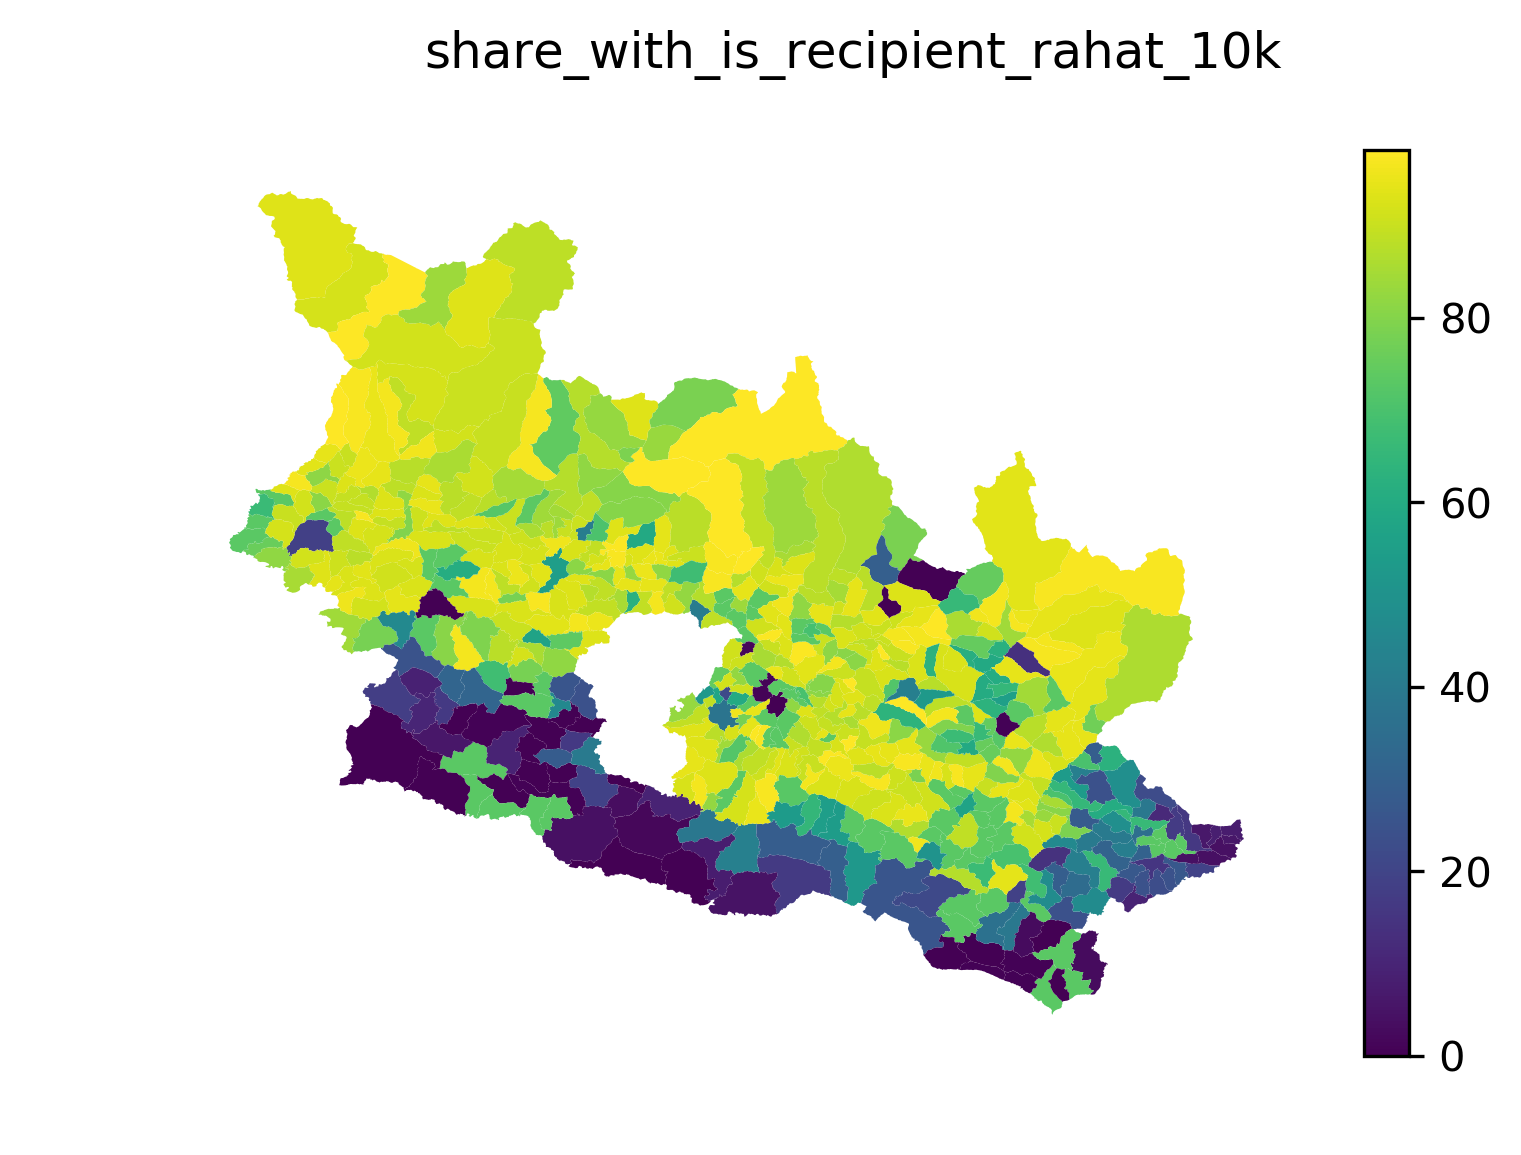

In [63]:
v = 'is_recipient_rahat_10k'
df = village_agg_indicator(v)
df['share_with_'+v].describe().T
plot_var_village(df,v,winsor=True)

count    565.000000
mean       2.636486
std        3.325370
min        0.000000
25%        1.315789
50%        2.092050
75%        3.128911
max       68.103448
Name: share_with_has_death_occurred_last_12_months, dtype: float64

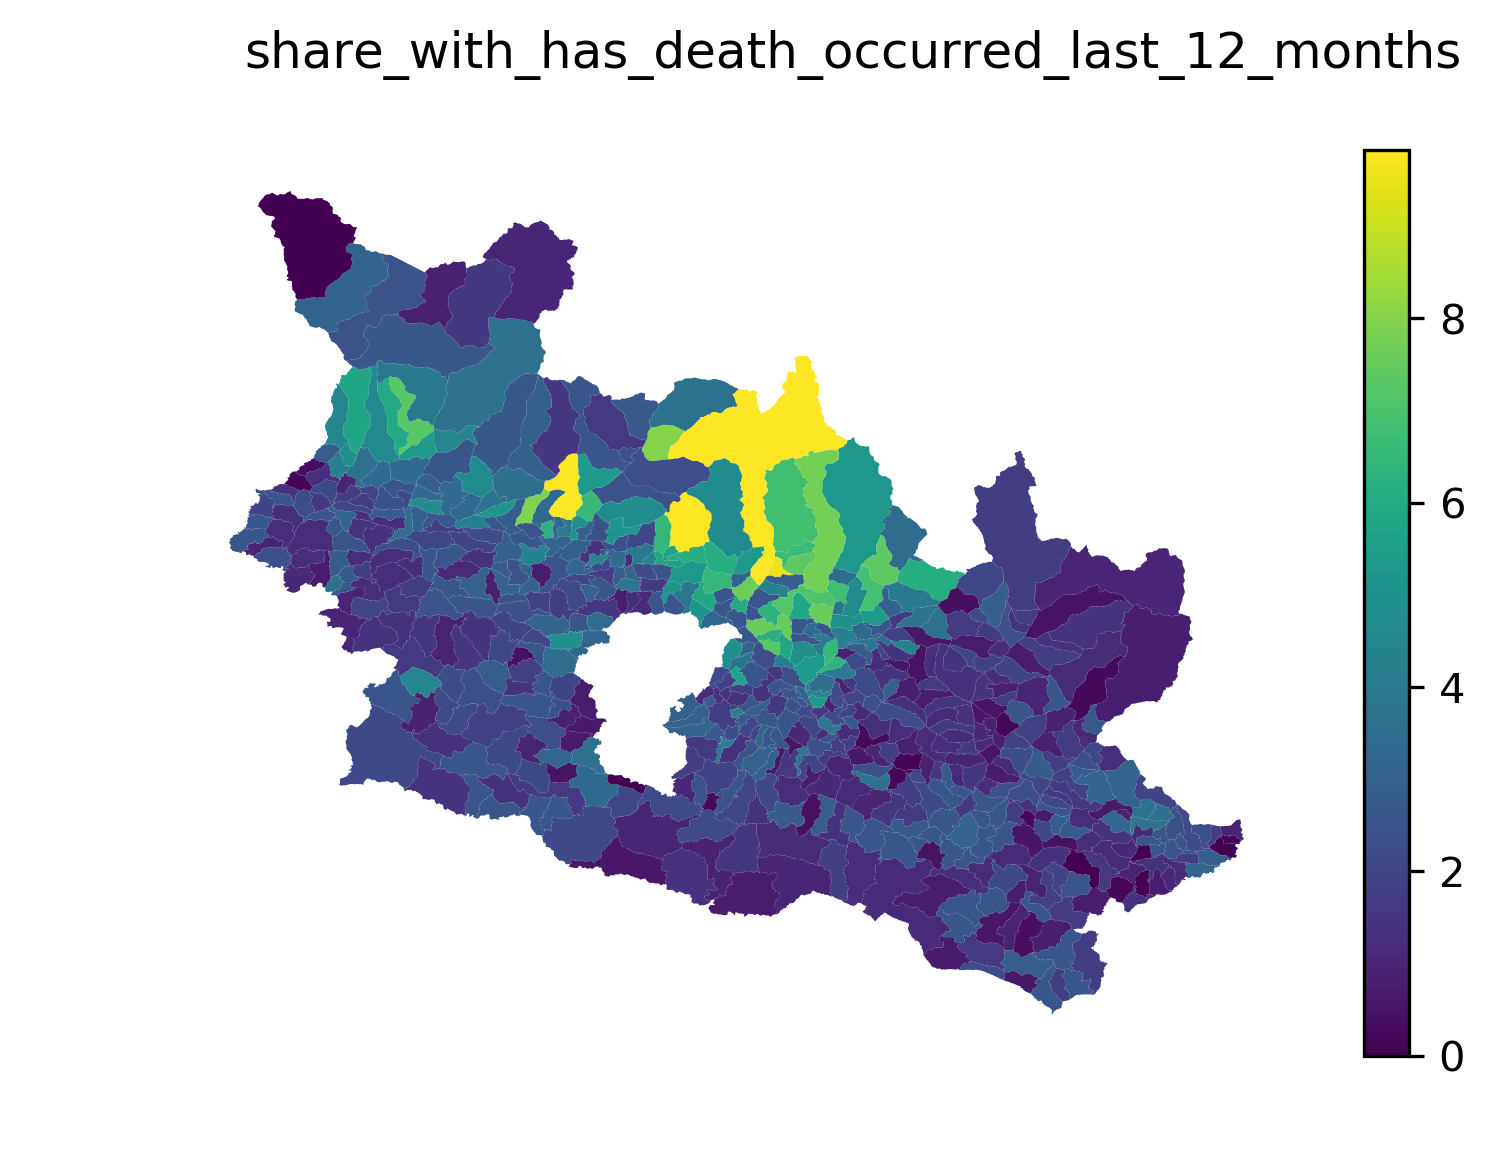

In [64]:
v = 'has_death_occurred_last_12_months'
df = village_agg_indicator(v)
df['share_with_'+v].describe().T
plot_var_village(df,v,winsor=True)

## Income $\mu$ and $\sigma$

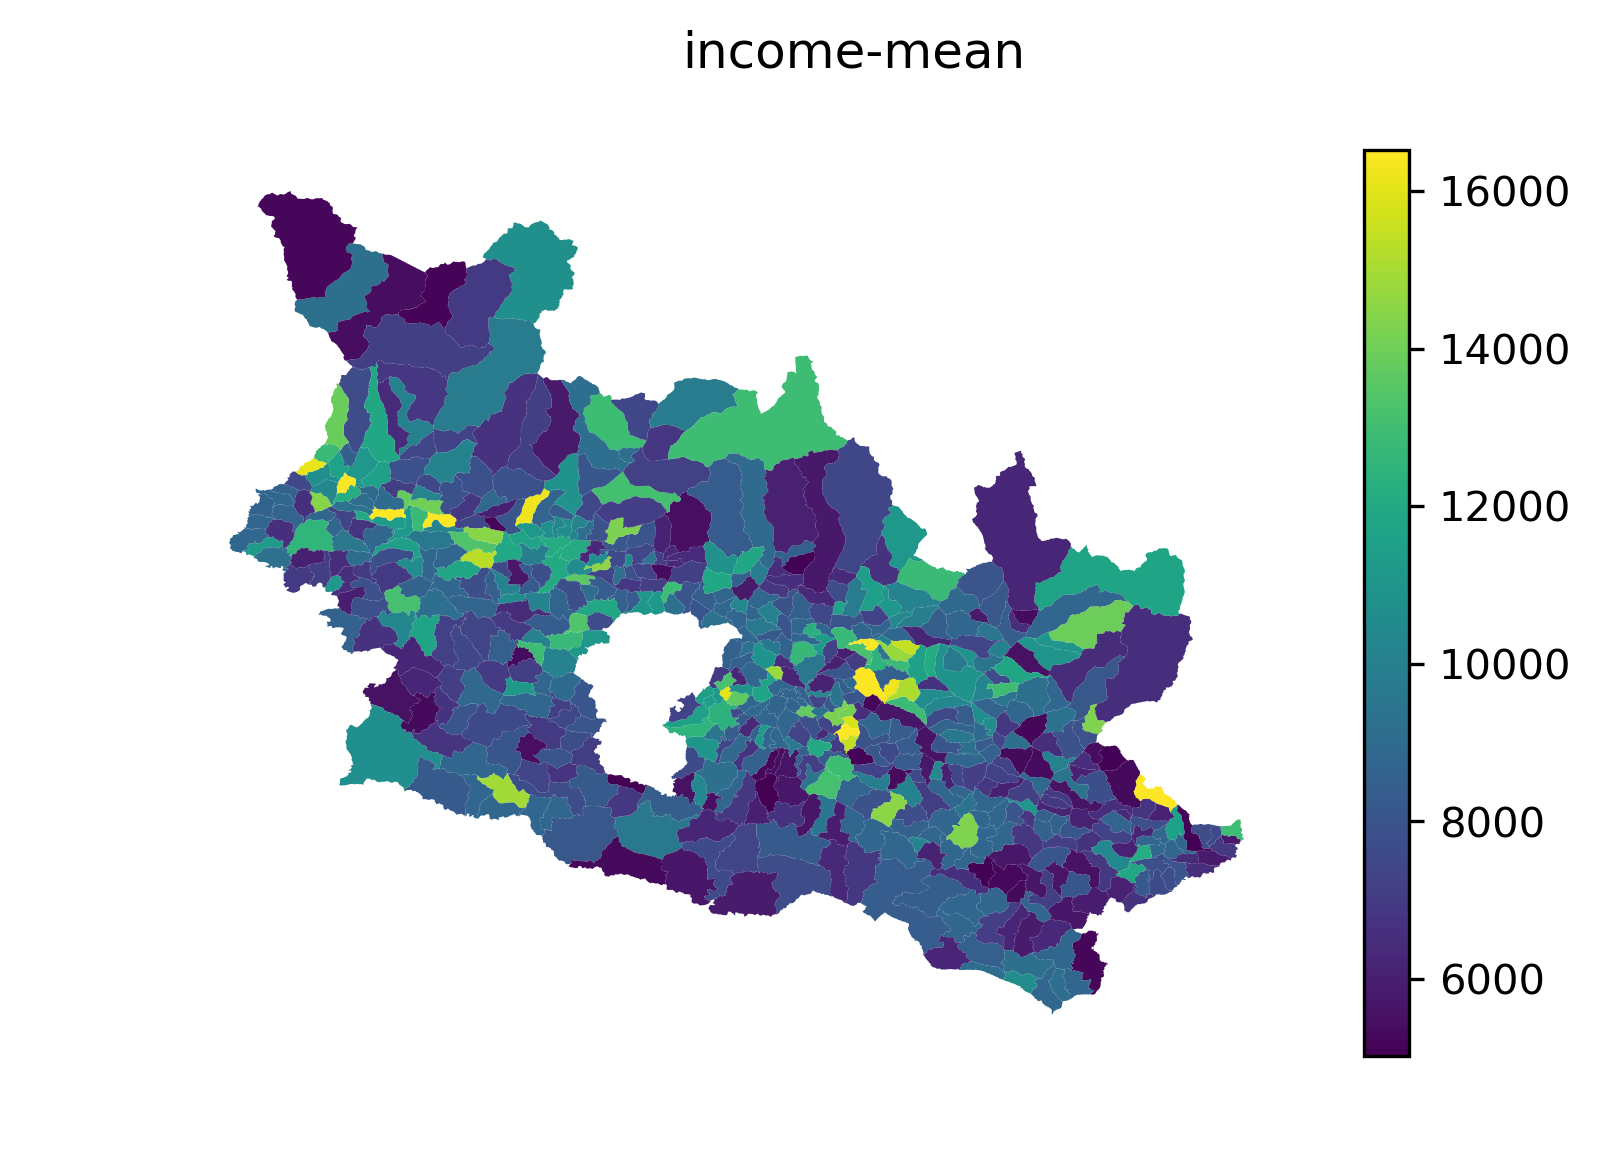

In [65]:
v = 'income'
df = village_agg_indicator(v,oper='mean')
plot_var_village(df,v,winsor=True,label=v+'-mean') 

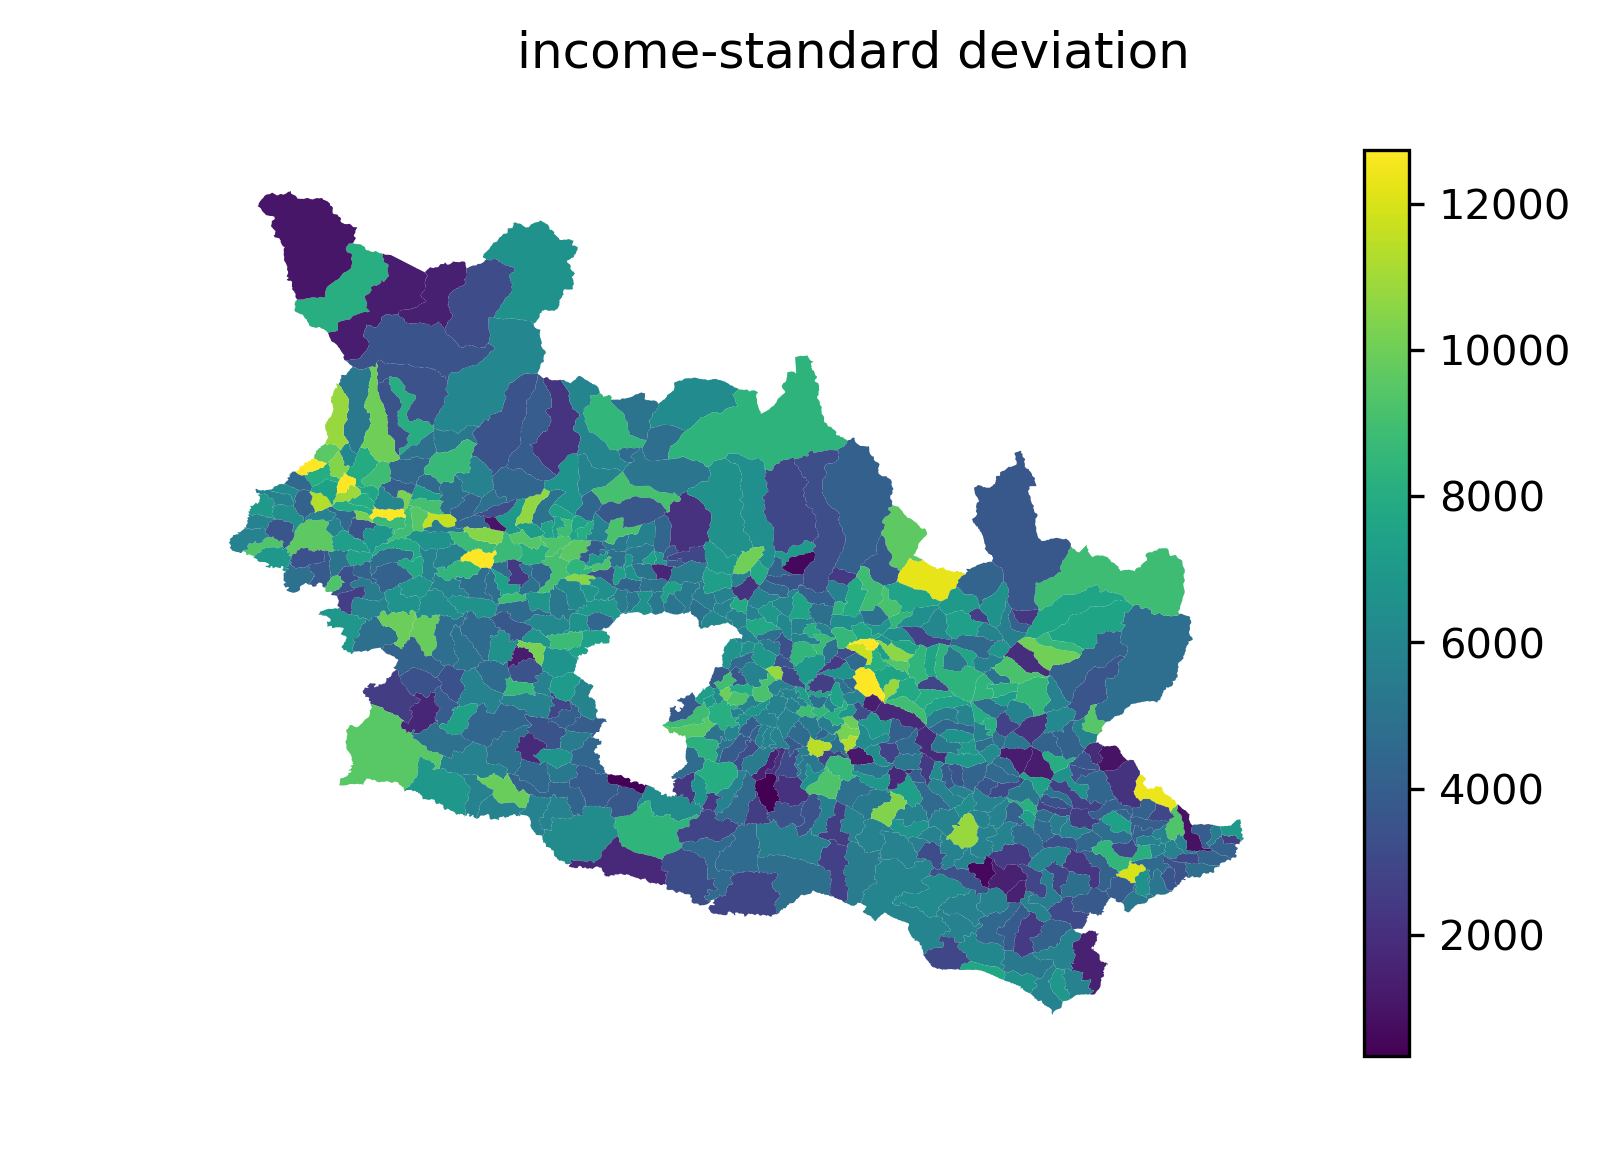

In [66]:
v = 'income'
df = village_agg_indicator(v,oper='std')
plot_var_village(df,v,winsor=True,label=v+'-standard deviation') 

## Plot all relevant variables and save

In [67]:
list_of_cols = ['is_bank_account_present_in_household',
    'has_injury_loss_occurred_last_12_months',
    'has_death_occurred_last_12_months',
    'has_education_drop_occurred_last_12_months',
    'has_pregnancy_treatment_drop_occurred_last_12_months',
    'has_vaccination_drop_occurred_last_12_months',
    'has_occupation_change_occurred_last_12_months',
    'count_occupation_change_last_12_months',
    'is_recipient_rahat_15k', 'is_recipient_rahat_10k',
    'is_recipient_rahat_200k', 'is_recipient_rahat_social_security_3k',
    'is_recipient_rahat_none', 'is_ineligible_rahat',
    'has_asset_land_pre_eq', 'has_asset_tv_pre_eq',
    'has_asset_cable_pre_eq', 'has_asset_computer_pre_eq',
    'has_asset_internet_pre_eq', 'has_asset_telephone_pre_eq',
    'has_asset_mobile_phone_pre_eq', 'has_asset_fridge_pre_eq',
    'has_asset_motorcycle_pre_eq',
    'has_asset_four_wheeler_family_use_pre_eq',
    'has_asset_four_wheeler_commercial_use_pre_eq', 'has_asset_none_pre_eq',
    'has_asset_land_post_eq', 'has_asset_tv_post_eq',
    'has_asset_cable_post_eq', 'has_asset_computer_post_eq',
    'has_asset_internet_post_eq', 'has_asset_telephone_post_eq',
    'has_asset_mobile_phone_post_eq', 'has_asset_fridge_post_eq',
    'has_asset_motorcycle_post_eq',
    'has_asset_four_wheeler_family_use_post_eq',
    'has_asset_four_wheeler_commercial_post_eq', 'has_asset_none_post_eq'
]

In [68]:
%cd $maproot

/home/alal/Desktop/code/0_research/eq-svy-eda/reports/maps


In [69]:
! mkdir 'village_level' -p

In [70]:
%cd 'village_level'

/home/alal/Desktop/code/0_research/eq-svy-eda/reports/maps/village_level


In [71]:
%%capture
for v in list_of_cols:
    plot_var_village(village_agg_indicator(v),
                     v,winsor=True,save=True)

## Village level by district 

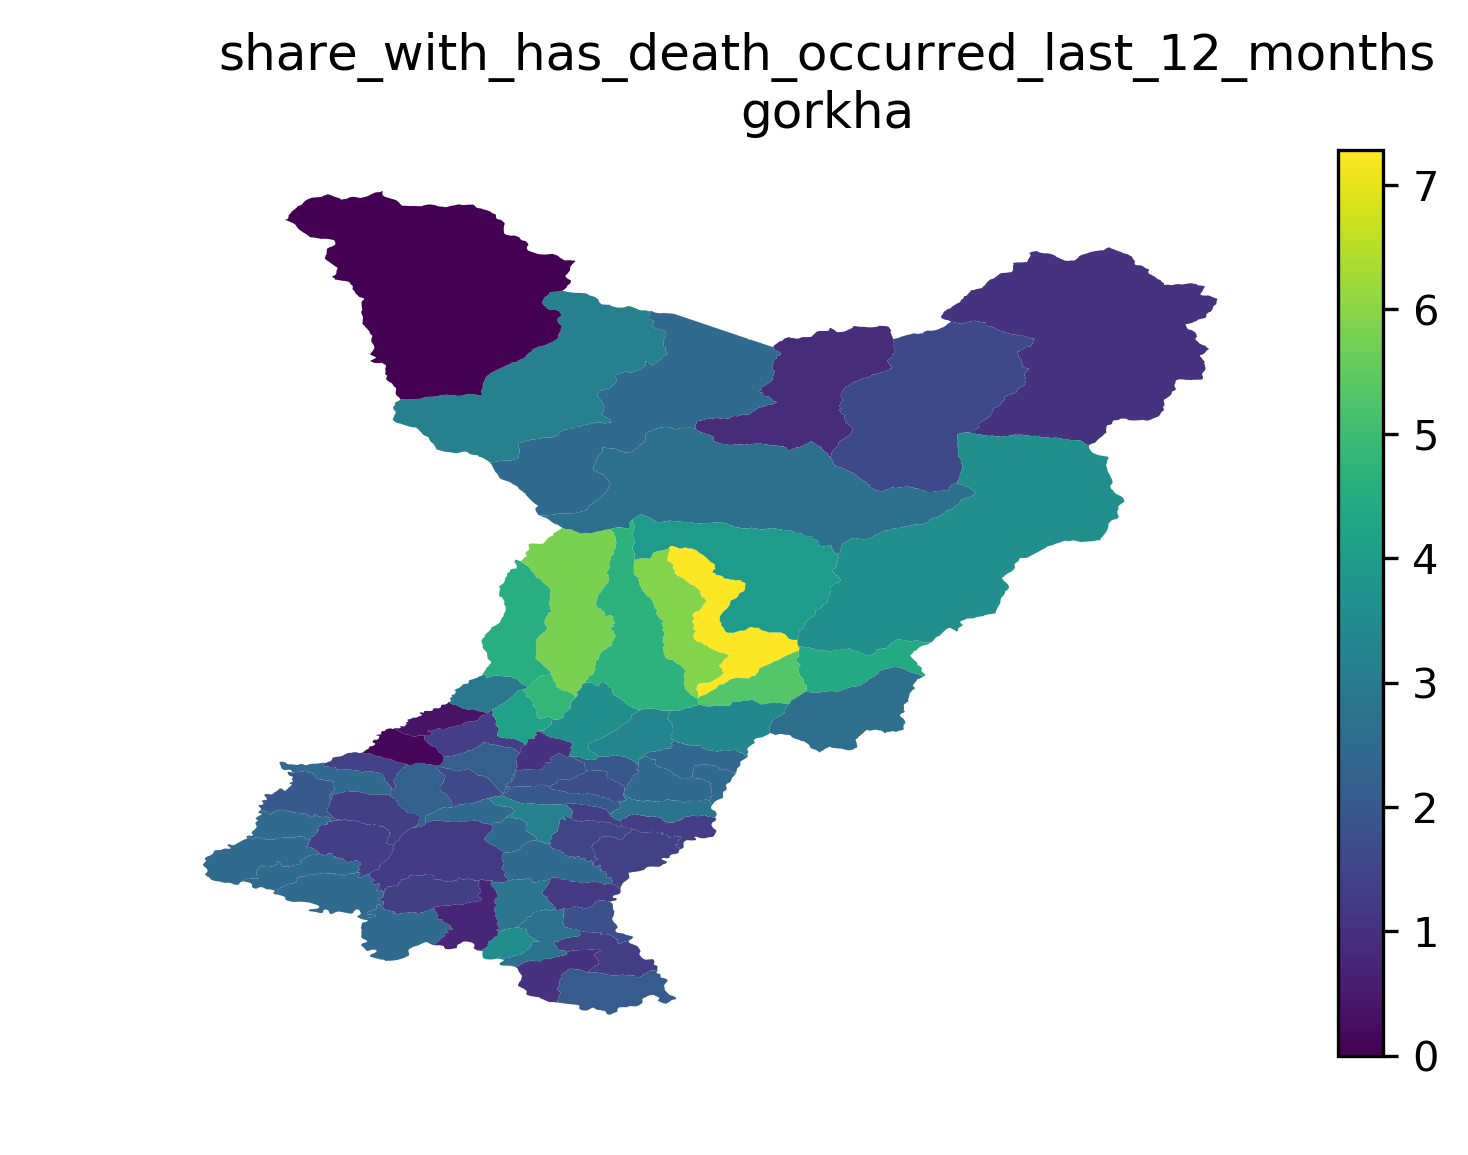

In [36]:
v = 'has_death_occurred_last_12_months'
df = village_agg_indicator(v)
plot_var_village(df,v,dist='gorkha',winsor=True)

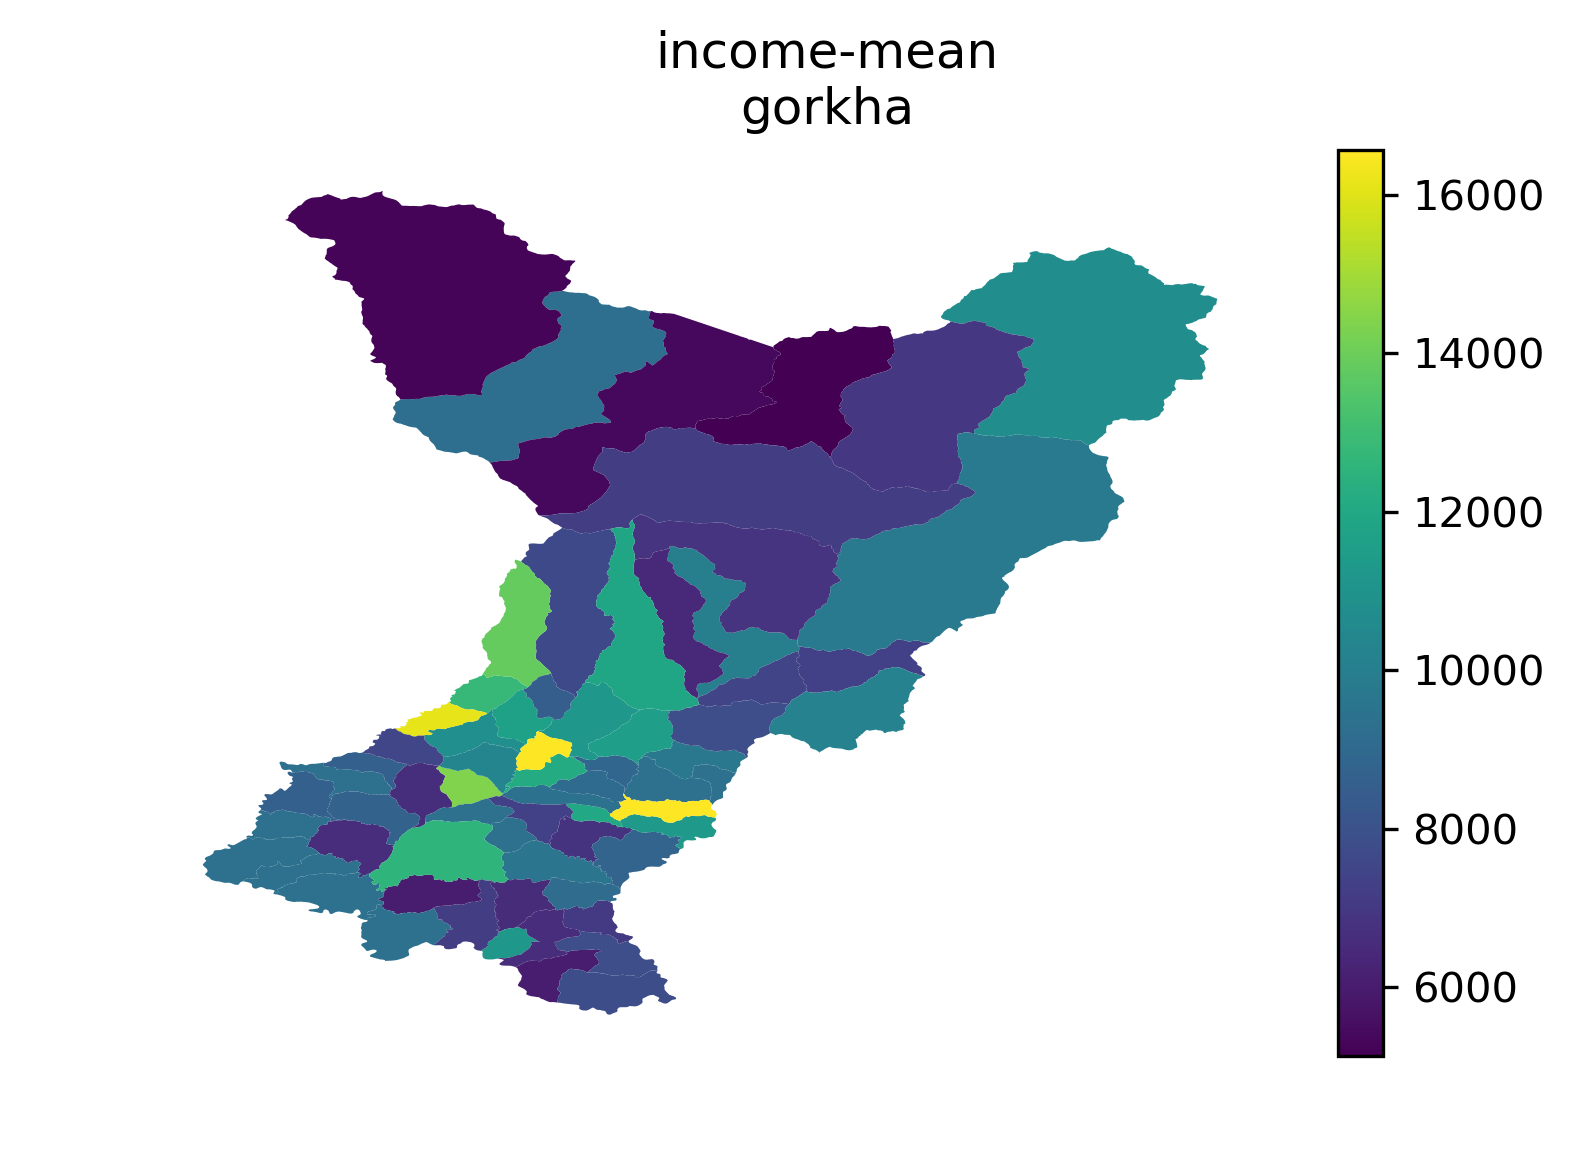

In [37]:
v = 'income'
d = 'gorkha'
df = village_agg_indicator(v,oper='mean')
plot_var_village(df,v,dist=d,winsor=True,label=v+'-mean') 

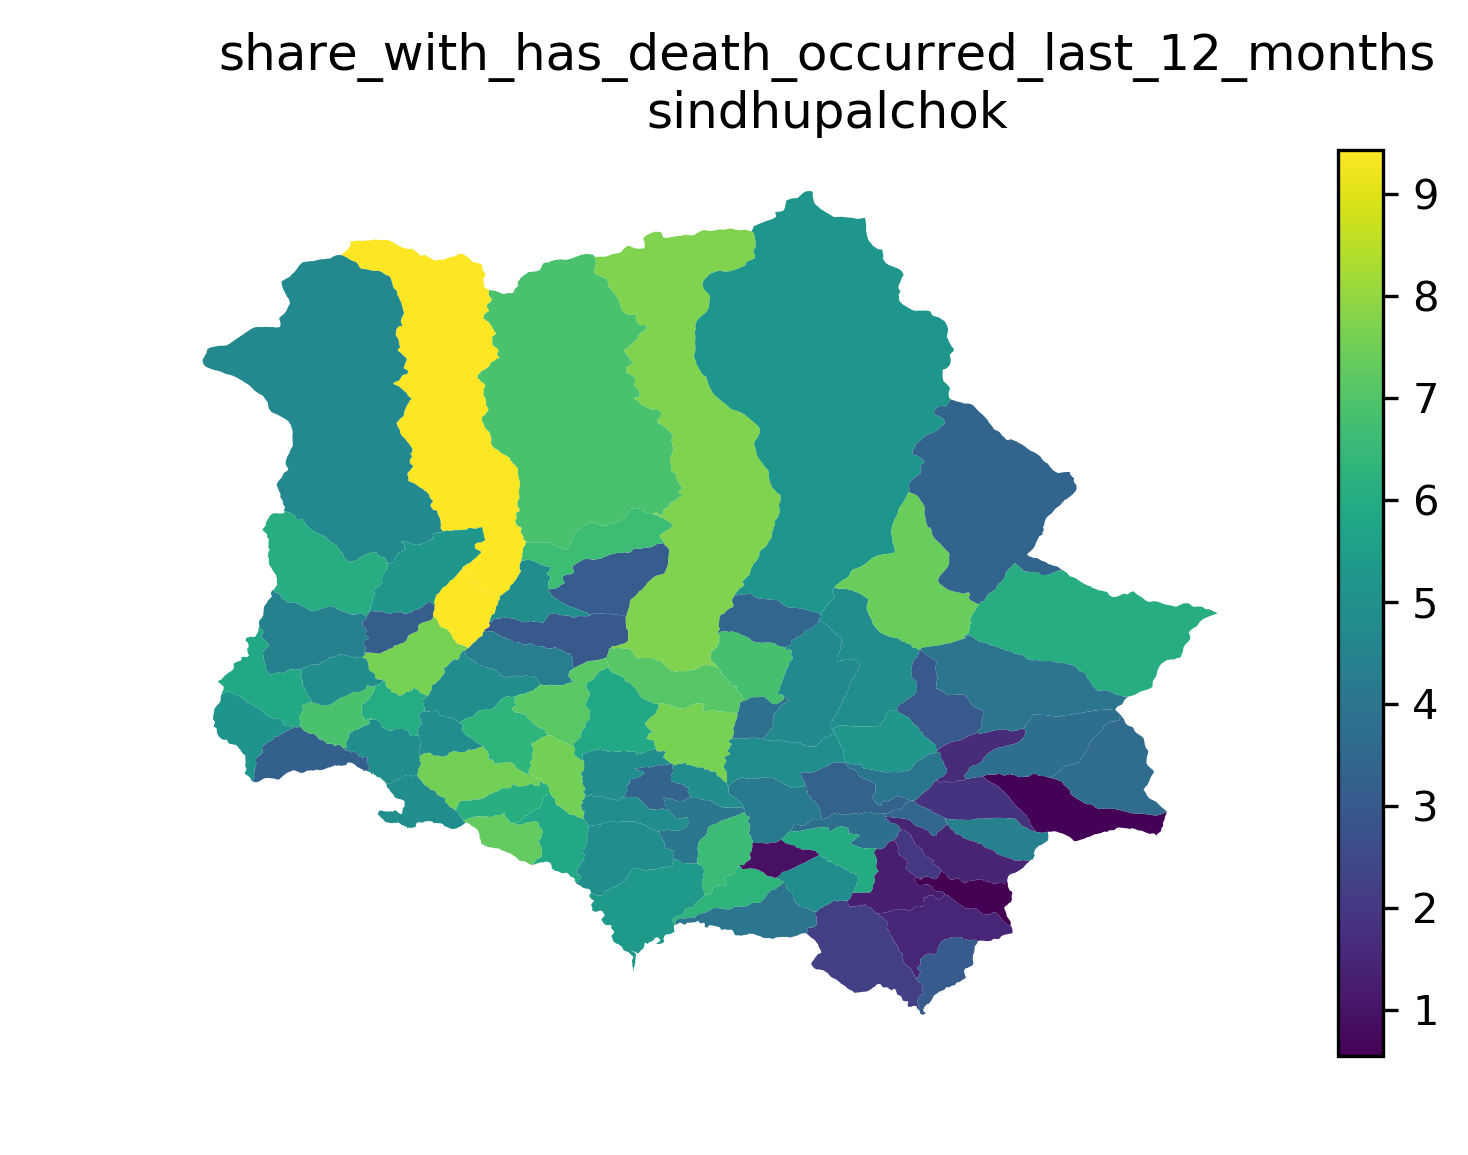

In [38]:
v = 'has_death_occurred_last_12_months'
d = 'sindhupalchok'
df = village_agg_indicator(v)
plot_var_village(df,v,dist=d,winsor=True)

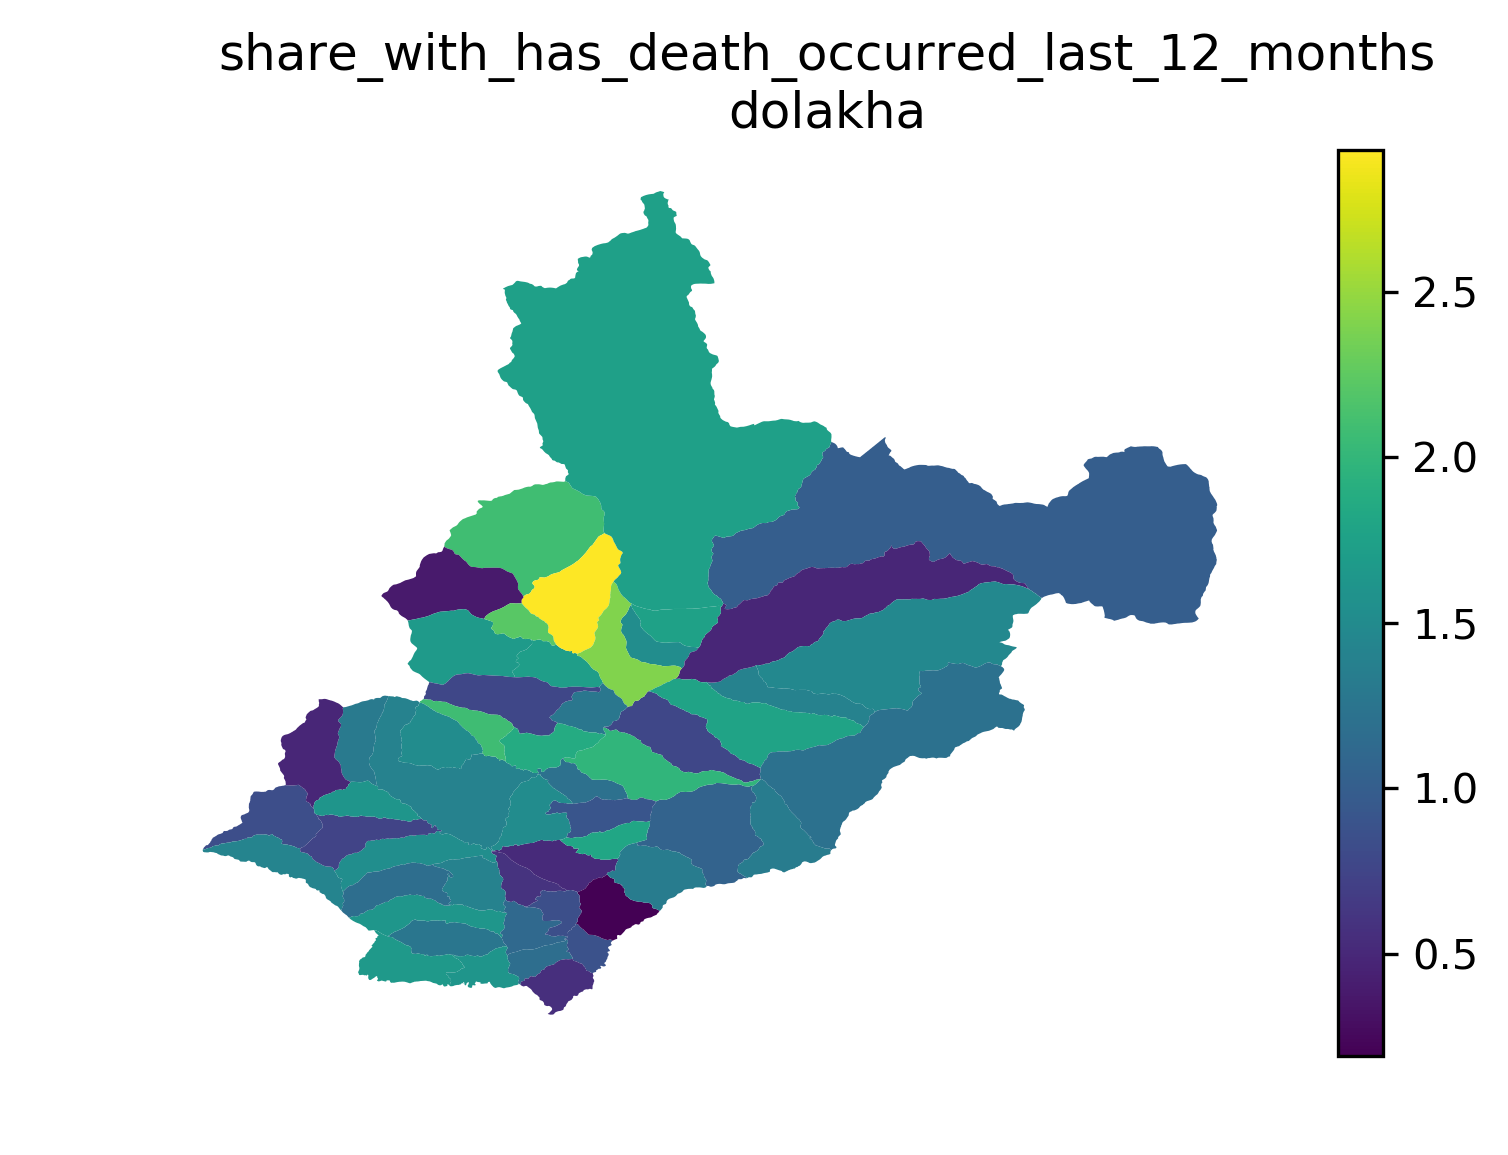

In [39]:
v = 'has_death_occurred_last_12_months'
d = 'dolakha'
df = village_agg_indicator(v)
plot_var_village(df,v,dist=d,winsor=True)

In [40]:
village_root = maproot+'/village_level'

In [41]:
%%time 
%%capture
for d in main_dists:
    os.chdir(village_root)
    dist_folder = village_root+'/'+d
    if not os.path.exists(dist_folder):
        os.makedirs(dist_folder)
    os.chdir(dist_folder)
    for v in list_of_cols:
        plot_var_village(village_agg_indicator(v),v,
                         dist=d,winsor=True,save=True)

CPU times: user 6min 51s, sys: 2min 53s, total: 9min 45s
Wall time: 5min 31s
